In [1]:
from openai import AzureOpenAI
from openai import OpenAI
from dotenv import load_dotenv

import pandas as pd
import os
import json
import ast

In [11]:
load_dotenv()

api_key = os.getenv('OPENAI_API_KEY')
api_base = os.getenv('ENDPOINT') # endpoint
deployment_name = 'gpt-4o'
api_version = '2024-02-15-preview'

In [12]:
client = AzureOpenAI(
    api_key = api_key,
    api_version = api_version,
    base_url =f"{api_base}/openai/deployments/{deployment_name}"
)

# Study Build Automation Activity

### Step 1: Extract the Visits / Activities from the Schedule of Activities / Schedule of Assessments (SOA)

#### Visits

In [17]:
visit_extraction_prompt = f'''
***Task: Visit Extraction Task**

You will be provided a set of one or more images representing a Schedule of Activities / Schedule of Assessments (SOA) from a Clinical Trial Protocol document. Your task is to extract the visit information from the Schedule of Activities / Schedule of Assessments (SOA) and populate the provided template file for building the electronic data capture (EDC) system. Make sure to capture all the required details from each visit, like the visit window. Do not output any text other than the final file for building the electronic data capture (EDC) system.

Below is the template for you ouput with provided sample data. Replace the sample data with your final output. Ensure the output rows are consistent with the data types defined in the template. You may leave rows blank.

name,description,label,window,type
E1,Screening encounter,Screening 1, -28 days,Visit
E2,Baseline ,Baseline, -3..3 days,Visit
E3,Day 14,Week 2, -3..3 days,Visit
E4,Day 28,Week 4, -3..3 days,Visit
E5,Day 42,Week 6, -3..3 days,Visit
E6,Day 56,Week 8, -4..4 days,Visit
E7,Day 84,Week 12, -4..4 days,Visit
E8,Day 112,Week 16, -4..4 days,Visit
E9,Day 140,Week 20, -4..4 days,Visit
E10,Day 168,Week 24, -3..3 days,Visit
E11,Day 182,Week 26, -3..3 days,Visit

Answer:
'''

### Vision-Based Extraction

Data URLs: ['', '', '', '']

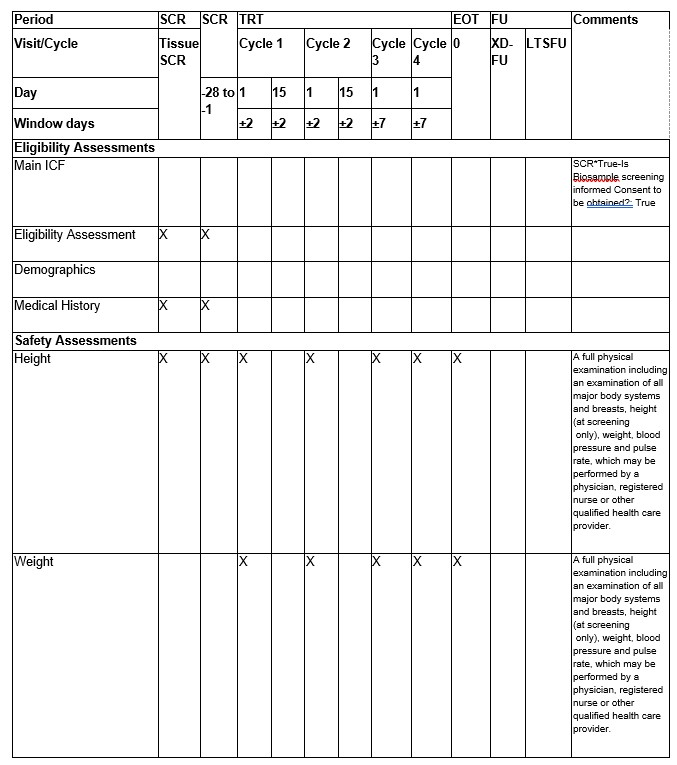
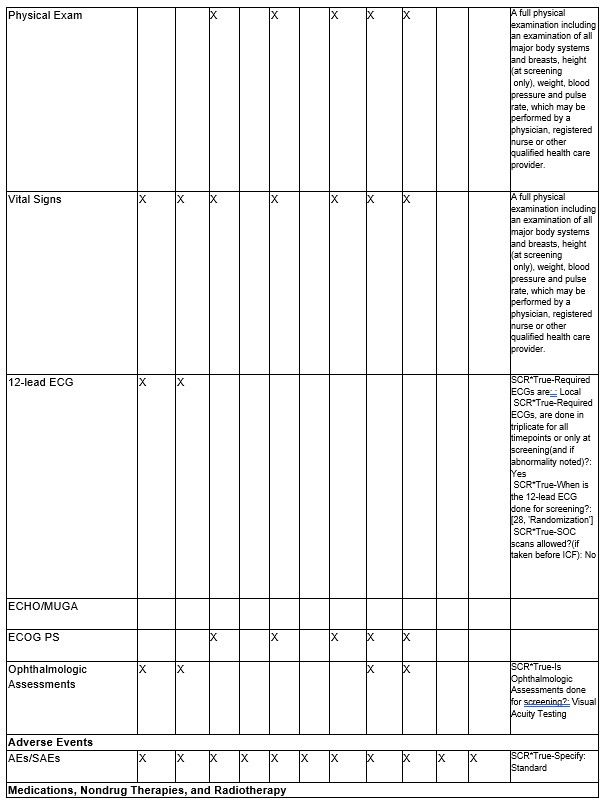
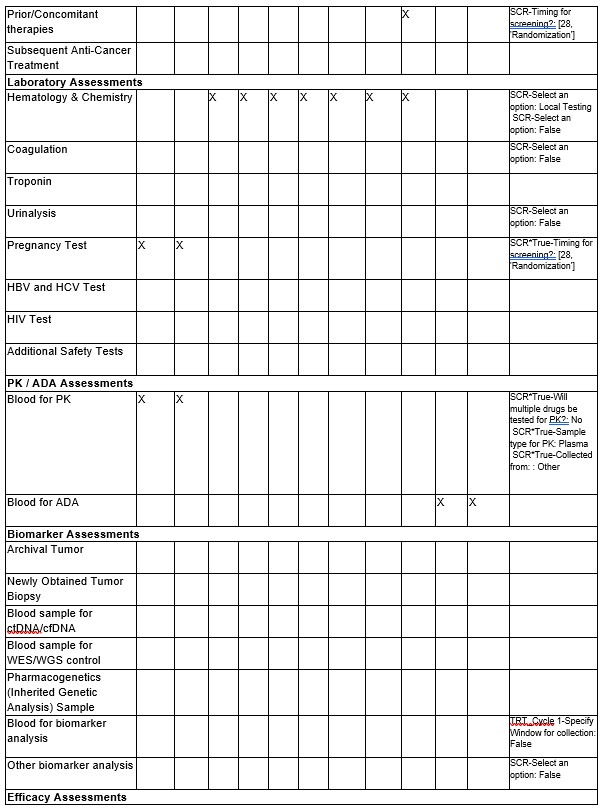
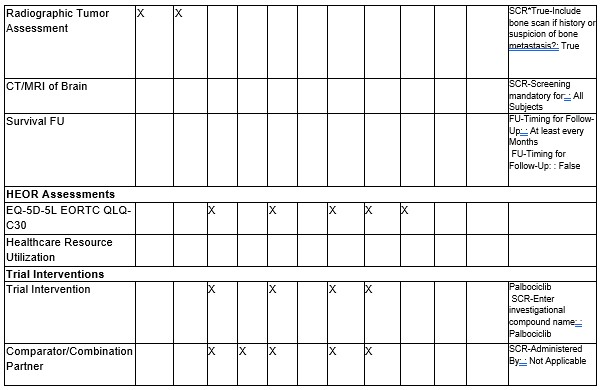

In [14]:
# GPT4 / GPT-4o Vision 
import base64
from mimetypes import guess_type

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

# Example usage
cwd = os.getcwd()

list_of_images = ['files/Pfizer_Paloma3/SOA_OSB_1.jpg', 'files/Pfizer_Paloma3/SOA_OSB_2.jpg', 'files/Pfizer_Paloma3/SOA_OSB_3.jpg', 'files/Pfizer_Paloma3/SOA_OSB_4.jpg']

count = 0
temp_l = []
for i in list_of_images:

    image_path = i
    image_path = os.path.normpath(image_path)
    image_path = os.path.join(cwd,image_path)
    data_url = local_image_to_data_url(image_path)
    temp_l.append(data_url)

print("Data URLs:", temp_l)

In [18]:
response = client.chat.completions.create(
    model = deployment_name,
    messages = [
        {"role": "system", "content": "You are a helpful assistant. "},
        {"role": "user", "content": [
            {
                "type": "text",
                "text": visit_extraction_prompt
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": temp_l[0]
                }
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": temp_l[1]
                }
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": temp_l[2]
                }
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": temp_l[3]
                }
            }
        ] }
    ],
    max_tokens= 4096,
    temperature = 0
)

#print(response)
print(response.choices[0].message.content)

name,description,label,window,type
E1,Screening encounter,Screening, -28 to -1 days,Visit
E2,Tissue Screening,Tissue SCR, -28 to -1 days,Visit
E3,Cycle 1,Day 1, ±2 days,Visit
E4,Cycle 1,Day 15, ±2 days,Visit
E5,Cycle 2,Day 1, ±2 days,Visit
E6,Cycle 2,Day 15, ±2 days,Visit
E7,Cycle 3,Day 1, ±7 days,Visit
E8,Cycle 4,Day 1, ±7 days,Visit
E9,End of Treatment,EOT, 0 days,Visit
E10,Follow-Up,Follow-Up, ,Visit
E11,Long-Term Survival Follow-Up,LTSFU, ,Visit


In [ ]:
visit_df = pd.DataFrame()